In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
# Read in data into dataframes
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size: ', test_features.shape)
print('Training Labels Size: ', train_labels.shape)
print('Testing Labels Size: ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Feature Size:  (2839, 64)
Training Labels Size:  (6622, 1)
Testing Labels Size:  (2839, 1)


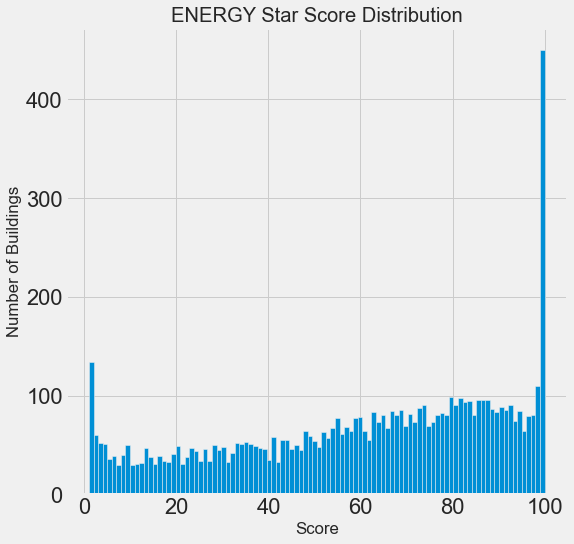

In [3]:
figsize (8,8)

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Score'); plt.ylabel('Number of Buildings');
plt.title('ENERGY Star Score Distribution');

In [4]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [5]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features: ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:  0


In [6]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [7]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0,1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [8]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

In [9]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evaluate
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [10]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' %lr_mae)

Linear Regression Performance on the test set: MAE = 13.4651


In [11]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 10.9337


In [12]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on test set: MAE = 9.5231


In [13]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 10.0116


In [14]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 13.0131


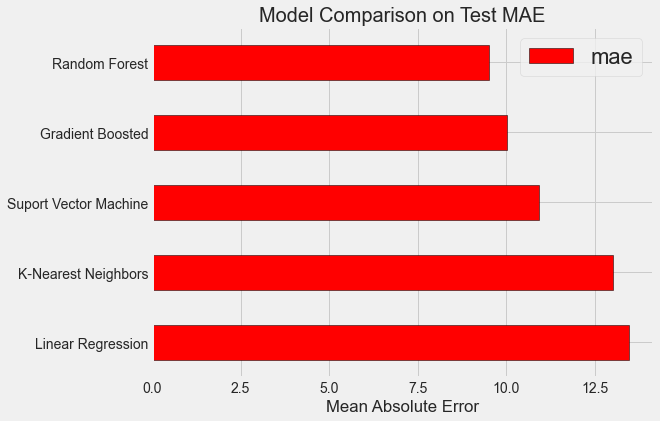

In [15]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Suport Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                           'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae,
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                            color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

In [16]:
# Loss function to be optimized
loss = ['ls', 'absolute_error', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators':  n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [17]:
# Create the model to use for the hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25,
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1,
                               return_train_score = True,
                               random_state = 42)

In [20]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


C:\Users\Jared\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(


RandomizedSearchCV(cv=4, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'loss': ['ls', 'lad', 'huber'],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 4, 6, 10],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

In [21]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,16.195648,0.172022,0.014503,0.000500,500,6,6,None,5,lad,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.924621,-8.775078,-9.325044,-9.037550,-9.015573,0.201473,1,-6.934705,-6.837958,-6.869084,-6.840749,-6.870624,0.038950
3,16.678961,0.114814,0.016254,0.000433,500,6,8,None,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.872066,-8.904065,-9.317120,-9.075047,-9.042074,0.176555,2,-4.384343,-4.326121,-4.823009,-4.229809,-4.440820,0.227453
9,10.432355,0.050019,0.010752,0.000433,500,4,2,auto,3,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.062882,-9.043722,-9.442664,-9.197954,-9.186805,0.159231,3,-6.955777,-7.088986,-6.913108,-6.949044,-6.976729,0.066811
0,2.776576,0.011543,0.006002,0.001732,100,2,6,auto,5,ls,"{'n_estimators': 100, 'min_samples_split': 2, ...",-9.100775,-9.026538,-9.456636,-9.201011,-9.196240,0.162589,4,-7.302003,-7.312645,-7.173397,-7.386171,-7.293554,0.076569
7,8.823239,0.073567,0.010752,0.000433,500,4,6,auto,3,ls,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.147703,-9.199444,-9.698622,-9.358627,-9.351099,0.215173,5,-7.089709,-7.103749,-7.021418,-7.080088,-7.073741,0.031358
10,79.611590,0.842559,0.070266,0.001786,1100,10,6,None,10,huber,"{'n_estimators': 1100, 'min_samples_split': 10...",-9.193406,-9.254552,-9.565642,-9.464933,-9.369633,0.151493,6,-0.376942,-0.419973,-0.417745,-0.385657,-0.400079,0.019047
19,22.220712,0.178334,0.018254,0.000433,1100,6,2,auto,3,lad,"{'n_estimators': 1100, 'min_samples_split': 6,...",-9.350800,-9.382812,-9.475236,-9.291753,-9.375150,0.066377,7,-8.513004,-8.658903,-7.820534,-8.017995,-8.252609,0.344461
2,47.256903,0.785268,0.038759,0.000829,500,4,2,auto,10,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.333559,-9.249347,-9.599790,-9.328477,-9.377793,0.132448,8,-0.167582,-0.180290,-0.155735,-0.139327,-0.160734,0.015104
16,26.086875,0.149842,0.028256,0.000829,1500,4,6,None,3,ls,"{'n_estimators': 1500, 'min_samples_split': 4,...",-9.248455,-9.315932,-9.797820,-9.427920,-9.447532,0.212154,9,-4.821677,-4.876202,-4.776650,-4.729506,-4.801009,0.054284
21,4.736816,0.028099,0.019255,0.002773,500,6,4,log2,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-9.365194,-9.286988,-9.751767,-9.409179,-9.453282,0.177800,10,-5.733003,-5.742441,-5.571781,-5.666476,-5.678425,0.068177


In [22]:
random_cv.best_estimator_

GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_leaf=6,
                          min_samples_split=6, n_estimators=500,
                          random_state=42)

In [29]:
# Creae a range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'absolute_error', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object using the tree range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4,
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [30]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


GridSearchCV(cv=4,
             estimator=GradientBoostingRegressor(loss='absolute_error',
                                                 max_depth=5,
                                                 min_samples_leaf=6,
                                                 min_samples_split=6,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                          450, 500, 550, 600, 650, 700, 750,
                                          800]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

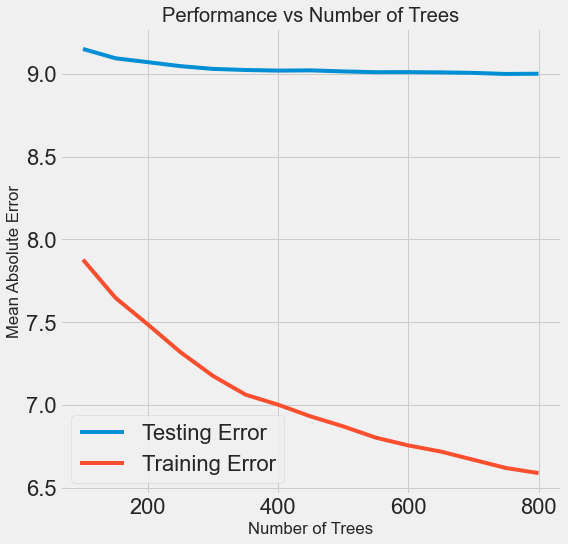

In [31]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Absolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [32]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
13,22.937817,0.172521,0.015254,0.000825,750,{'n_estimators': 750},-8.901092,-8.751699,-9.298411,-9.049730,-9.000233,0.201840,1,-6.716494,-6.660453,-6.520818,-6.579989,-6.619438,0.074807
14,22.441379,0.260997,0.015503,0.000500,800,{'n_estimators': 800},-8.903857,-8.758299,-9.296941,-9.047485,-9.001645,0.198797,2,-6.689643,-6.648109,-6.486269,-6.530287,-6.588577,0.083101
12,22.662049,0.601377,0.017004,0.001871,700,{'n_estimators': 700},-8.904269,-8.755862,-9.312990,-9.053755,-9.006719,0.205815,3,-6.743886,-6.695770,-6.611240,-6.624919,-6.668953,0.053861
11,22.044640,0.575869,0.017265,0.000427,650,{'n_estimators': 650},-8.906208,-8.755401,-9.325190,-9.052215,-9.009754,0.210191,4,-6.778068,-6.721452,-6.708191,-6.666758,-6.718617,0.039814
9,17.874529,0.049108,0.015003,0.000707,550,{'n_estimators': 550},-8.918502,-8.756938,-9.325492,-9.042721,-9.010913,0.207975,5,-6.874737,-6.781878,-6.809121,-6.745712,-6.802862,0.047201


In [ ]:
# Default model
default_model =